# External drift kriging

This exercise does not require you to programm anything. However, it is way more sophisticated from a software development perspective. So take your time to try to understand what is happening.

**There are two sections, loading external drift data. You only need one of them**


In [ ]:
pip install rioxarray scikit-gstat

In [ ]:
from  google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path

PATH = Path('/content/drive/MyDrive/Geostatistics/content/data')

## DEM data

We will use this data throughout the notebook.

**In order to make this step work, you need to run the 'download_from_gee.ipynb' first and rename the resulting DEM of Baden-Württemberg to `dem_bw.tif`.**

In [ ]:
# load the data
import rioxarray
import xarray as xr

bawu = xr.open_dataset(PATH / 'dem_bw.tif', mask_and_scale=True, chunks='auto')
bawu

<xarray.Dataset>
Dimensions:      (band: 1, x: 332, y: 252)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.514 7.523 7.532 7.541 ... 10.46 10.47 10.48 10.49
  * y            (y) float64 49.79 49.78 49.77 49.76 ... 47.56 47.55 47.54 47.53
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 252, 332), meta=np.ndarray>

This cell turns the geotiff into a long-format Dataframe. For now, we keep the NaNs, which represent cells outside the bounds of Baden-Württemberg. We will adjust the Kriging to ignore these cells, but we need all original locations, so that we can transform the results easily

In [ ]:
# export to dataframe, use ony coords and band_data -> remove nans
dem_arr = bawu.to_dataframe().reset_index()[['x', 'y', 'band_data']]#.dropna()
dem_arr

,x,y,band_data
0,7.514407,49.789125,NaN
1,7.514407,49.780141,NaN
2,7.514407,49.771158,NaN
3,7.514407,49.762175,NaN
4,7.514407,49.753192,NaN
...,...,...,...
83659,10.487831,47.570286,NaN
83660,10.487831,47.561303,NaN
83661,10.487831,47.552320,NaN
83662,10.487831,47.543336,NaN


Here, like always, the coordinates are transformed and we finally have the external drift data available.

In [ ]:
import numpy as np
import pyproj

# create a transform
src = pyproj.CRS.from_epsg(4326)
tgt = pyproj.CRS.from_epsg(25832)
transform = pyproj.Transformer.from_crs(src, tgt, always_xy=True)

# apply transformation
tuples = transform.transform(dem_arr.x.values, dem_arr.y.values)

# create the coordinates and values list
dem_coords = np.fromiter((zip(*tuples)), dtype=np.dtype((float, 2)))
dem_vals = dem_arr.band_data.values

Next we load the data downloaded for the sample that we use for interpolation. In this particular case, the data also has a height information. We can use that for the regression. For other drift data, we would need to align that with the sample.

In [ ]:
import pandas as pd

data = pd.read_csv(PATH / 'precipitation_sums_2023-06-01.csv')
data = data.where(data.state == 'Baden-Württemberg').dropna()
data

,station_id,start_date,end_date,latitude,longitude,height,name,state,geometry,value,quality
19,257.0,1881-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.7270,8.2457,240.0,Baden-Baden-Geroldsau,Baden-Württemberg,POINT (8.2457 48.727),44.2,3.0
20,259.0,1881-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,47.8064,7.6387,275.0,Müllheim,Baden-Württemberg,POINT (7.6387 47.8064),69.5,3.0
49,755.0,1881-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,49.5182,9.3213,340.0,"Buchen, Kr. Neckar-Odenwald",Baden-Württemberg,POINT (9.3213 49.5182),12.7,3.0
50,757.0,1990-10-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,47.9625,7.9983,445.0,Buchenbach,Baden-Württemberg,POINT (7.9983 47.9625),60.9,3.0
74,1197.0,1931-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.9895,10.1312,463.0,Ellwangen-Rindelbach,Baden-Württemberg,POINT (10.1312 48.9895),18.3,3.0
77,1214.0,1987-11-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.2012,8.1088,431.0,Elzach-Fisnacht,Baden-Württemberg,POINT (8.1088 48.2012),34.7,3.0
78,1224.0,1975-11-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.1378,7.8351,201.0,Emmendingen-Mundingen,Baden-Württemberg,POINT (7.8351 48.1378),49.6,3.0
80,1255.0,2002-12-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,49.1661,8.8483,226.0,Eppingen-Elsenz,Baden-Württemberg,POINT (8.8483 49.1661),21.0,3.0
88,1346.0,1921-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,47.8748,8.0038,1486.0,Feldberg/Schwarzwald,Baden-Württemberg,POINT (8.0038 47.8748),89.0,3.0
94,1443.0,1868-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.0232,7.8343,237.0,Freiburg,Baden-Württemberg,POINT (7.8343 48.0232),43.9,3.0


The important step missing is the regression model.
We define a linear and a quadratic model, fit both the drift distributed along with the sample and plot everything

Text(0, 0.5, 'Precipitation')

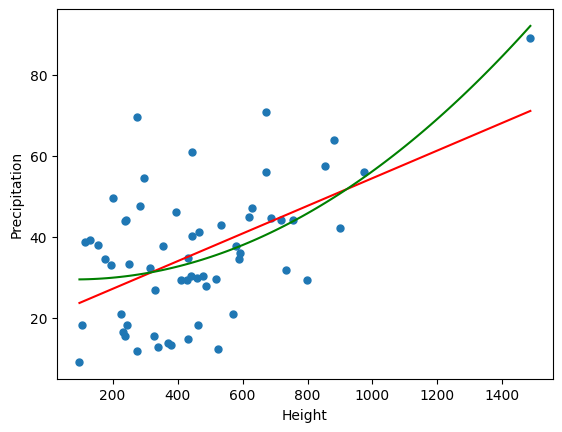

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# define a model
def linear(h, m, b):
  return m * h + b

def quad(h, a, b, c):
  return a * h**2 + b * h + c

# fit both models
cof_l, _ = curve_fit(linear, data.height, data.value)
cov_q, _ = curve_fit(quad, data.height, data.value)

# visualize
# discretize
x = np.linspace(data.height.min(), data.height.max(), 100)
fig, ax = plt.subplots(1, 1)
ax.scatter(data.height, data.value, 25)
ax.plot(x, linear(x, *cof_l), 'r')
ax.plot(x, quad(x, *cov_q), 'g')
ax.set_xlabel('Height')
ax.set_ylabel('Precipitation')


In [ ]:
# convert the coords
# apply transformation
tuples = transform.transform(data.longitude.values, data.latitude.values)

# create the coordinates and values list
coordinates = list(zip(*tuples))
values = data.value.values.tolist()

In [ ]:
# calcualte the residuals
res_l = linear(data.height, *cof_l) - data.value
res_q = quad(data.height, *cov_q) - data.value

print('Linear: ', np.sqrt((res_l**2).mean()))
print('Quad:   ', np.sqrt((res_q**2).mean()))

Linear:  13.991176804570674
Quad:    13.512835791025523


The cell above calculates the RMSE for both models. They show the same performance, but we select the linear model.

The reason is that it is the simpler model and, more importantly, The quadratic show unreasonable 'behavior'.

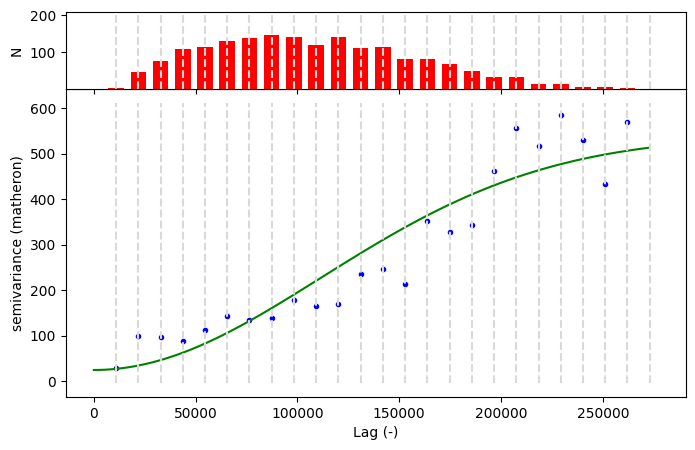

In [ ]:
from skgstat  import Variogram
vario = Variogram(coordinates, res_l, n_lags=25, model="stable", use_nugget=True)

fig = vario.plot()

That above is the variogram of the residuals. If the residuals of the drift do not show a spatial covariance, you cannot do KED.

With the cell below, I transfer all variables into variables of common names. So `VARIO` will be the variogram model, `DRIFT_MODEL` the regression model I want to use. Use can replace the variables easily (ie. with other drift data or other variogram parameters) without having to change you code all over the place.


In [ ]:
# define the input data

VARIO = vario
EXT_DRIFT = dem_arr
DRIFT_MODEL = lambda h: linear(np.asarray(h), *cof_l)
OBSERVATIONS = values

# here you usually need to subset EXT_DRIFT for the drift at the variogram coordiantes
OBS_DRIFT = data.height.values

## GPM data

This part can be used **INSTEAD** of the height data. It needs adjustments.

In [ ]:
import rioxarray
import xarray as xr

gpm = xr.open_dataset(PATH / 'gpm_by.tif', mask_and_scale=True, chunks='auto')
gpm_arr = gpm.to_dataframe().reset_index()[['x', 'y', 'band_data']].dropna()
gpm_arr

,x,y,band_data
4,9.5,47.5,250.094582
6,9.5,49.5,117.952835
7,9.5,50.5,62.860944
8,10.5,47.5,124.751866
9,10.5,48.5,100.408825
10,10.5,49.5,74.535851
11,10.5,50.5,65.693012
12,11.5,47.5,82.267894
13,11.5,48.5,106.256450
14,11.5,49.5,97.118742


from matplotlib import pyplot as plt
gpm_arr['x'].plot(kind='hist', bins=20, title='x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gpm_arr['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gpm_arr['band_data'].plot(kind='hist', bins=20, title='band_data')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gpm_arr.plot(kind='scatter', x='x', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gpm_arr.plot(kind='scatter', x='y', y='band_data', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['x']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = gpm_arr.sort_values('x', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('x')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['x']
  ys = series['band_data']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = gpm_arr.sort_values('x', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('x')
_ = plt.ylabel('band_data')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['x']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'x'}, axis=1)
              .sort_values('x', ascending=True))
  xs = counted['x']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = gpm_arr.sort_values('x', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('x')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
gpm_arr['x'].plot(kind='line', figsize=(8, 4), title='x')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
gpm_arr['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
gpm_arr['band_data'].plot(kind='line', figsize=(8, 4), title='band_data')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import pandas as pd

data = pd.read_csv(PATH / 'precipitation_sums_2023-06-01.csv')
data = data.where(data.state == 'Bayern').dropna()
data

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np

# use the data and search for the closest gpm value
gpms = []

for i, row in data.iterrows():
  # calcualte the distance to all rows
  dist = cdist(gpm_arr[['x', 'y']], [[row.longitude, row.latitude]], 'euclidean')
  # print(dist.flatten())
  closest = np.argmin(dist.flatten())
  gpms.append(gpm_arr.iloc[closest].band_data)

# add the data
data['gpm'] = gpms
data

,station_id,start_date,end_date,latitude,longitude,height,name,state,geometry,value,quality,gpm
1,73.0,1952-07-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.6183,13.0620,374.0,Aldersbach-Kramersepp,Bayern,POINT (13.062 48.6183),35.0,3.0,149.764728
6,142.0,1955-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.4060,11.3117,511.0,Altomünster-Maisbrunn,Bayern,POINT (11.3117 48.406),46.1,3.0,106.256450
8,151.0,1955-03-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,49.4691,11.8546,382.0,Amberg-Unterammersricht,Bayern,POINT (11.8546 49.4691),25.3,3.0,97.118742
9,154.0,1994-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.0197,12.2925,516.0,Amerang-Pfaffing,Bayern,POINT (12.2925 48.0197),44.6,3.0,97.822215
14,191.0,1884-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,49.9694,9.9114,217.0,Arnstein-Müdesheim,Bayern,POINT (9.9114 49.9694),29.5,3.0,117.952835
...,...,...,...,...,...,...,...,...,...,...,...,...
432,7412.0,2006-10-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,50.0083,9.4238,340.0,Neuhütten/Spessart,Bayern,POINT (9.4238 50.0083),35.4,3.0,62.860944
434,7424.0,2006-12-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,47.7724,12.9073,457.0,Piding,Bayern,POINT (12.9073 47.7724),37.9,3.0,99.519398
437,7431.0,2007-11-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.0130,11.5524,604.0,Oberhaching-Laufzorn,Bayern,POINT (11.5524 48.013),74.3,3.0,106.256450
444,13710.0,2008-04-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.5734,12.2576,490.0,Landshut-Reithof,Bayern,POINT (12.2576 48.5734),28.5,3.0,97.822215


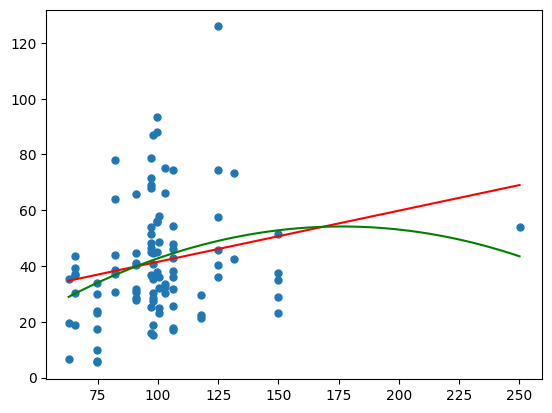

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# define a model
def linear(h, m, b):
  return m * h + b

def quad(h, a, b, c):
  return a * h**2 + b * h + c

# fit both models
cof_l, _ = curve_fit(linear, data.gpm, data.value)
cov_q, _ = curve_fit(quad, data.gpm, data.value)

# visualize
# discretize
x = np.linspace(data.gpm.min(), data.gpm.max(), 100)
plt.scatter(data.gpm, data.value, 25)
plt.plot(x, linear(x, *cof_l), 'r')
plt.plot(x, quad(x, *cov_q), 'g')

In [ ]:
# calcualte the residuals
res_l = linear(data.gpm, *cof_l) - data.gpm
res_q = quad(data.gpm, *cov_q) - data.gpm

print('Linear: ', np.sqrt((res_l**2).mean()))
print('Quad:   ', np.sqrt((res_q**2).mean()))

Linear:  61.89492040830793
Quad:    61.993982135627355


In [ ]:
# convert the coords
# apply transformation
tuples = transform.transform(data.longitude.values, data.latitude.values)

# create the coordinates and values list
coordinates = list(zip(*tuples))
values = data.value.values
ext_drift = data.gpm.values

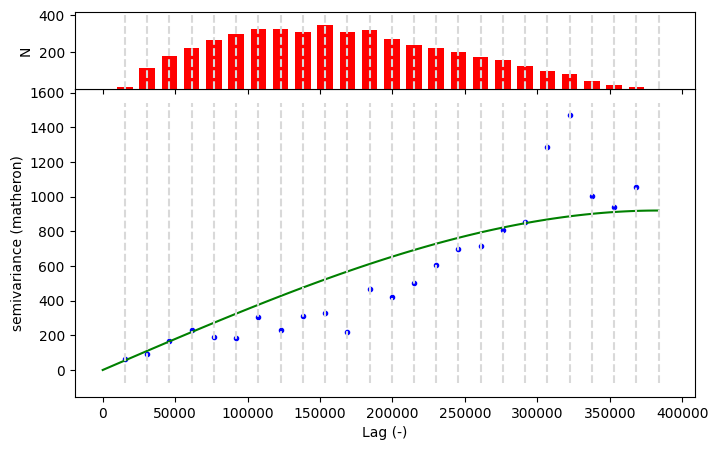

In [ ]:
from skgstat  import Variogram
vario = Variogram(coordinates, res_l, n_lags=25)

fig = vario.plot()

In [ ]:
# define the input data

VARIO = vario
EXT_DRIFT = ext_drift
DRIFT_MODEL = lambda h: linear(np.asarray(h), *cof_l)
OBSERVATIONS = values

# here you usually need to subset EXT_DRIFT for the drift at the variogram coordiantes
OBS_DRIFT = data.gpm.values

## Implement KED

This is the KED implementation. The code is functional, there are no adjustments needed. Try to understand the logic behind the implementation.

In [ ]:
from typing import Callable
import numpy as np
from skgstat import Variogram
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import inv
from tqdm import tqdm

class KED:
  def __init__(self, drift_model: Callable[[np.ndarray], np.float64], max_n: int = 15, verbose: bool = True):
    self.drift_model = drift_model
    self.max_n = max_n
    self.verbose = verbose

    # set the stuff that has to be fitted
    self.variogram = None
    self.drift_data = None
    self.obs_data = None

  def fit(self, variogram: Variogram, drift_data: np.ndarray, observations: np.ndarray):
    # set the variogram params
    self.variogram = variogram

    self.eff_range = variogram.parameters[0]
    self.obs_coords = self.variogram.coordinates
    self.obs_resids = self.variogram.values

    # set the other sample data
    self.obs_drift = drift_data
    self.obs_values = observations

    return self

  def predict(self, coordinates: np.ndarray, ext_drift: np.ndarray, mp: bool = False):
    if not self._isvalid:
      raise RuntimeError("This KED instance has not been fitted to a variogram. Call KED.fit and pass variogram and drift data")

    # check that the length matches
    if len(coordinates) != len(ext_drift):
      raise ValueError("Coordinates and ext_drift must have the same length")

    # if no multiprocessing, it's easy
    if not mp:
      # create a map on the grid
      grid_map = map(self._p_ked, coordinates, ext_drift)
      if self.verbose:
        grid_map = tqdm(grid_map, total=len(coordinates))

      con = np.fromiter(grid_map, dtype=np.dtype((float, 2)))

      return con[:, 0], con[:, 1]

    else:
      raise NotImplementedError("Multiprocessing not implemented")

  @property
  def _isvalid(self):
    if self.variogram is None or self.obs_drift is None or self.obs_values is None:
      return False
    return True

  def _select_observations_by_range(self, p0):
    if not self._isvalid:
      raise RuntimeError("This KED instance has not been fitted to a variogram. Call KED.fit and pass variogram and drift data")

    # calculate the distance from p0 to all coordinates
    dists = cdist(self.obs_coords, [p0], 'euclidean').flatten()

    # get the sorting index for dists
    indices = np.argsort(dists)

    # mask everything that is outside the effective range
    mask = [dists[i] > self.eff_range for i in indices]

    # now filter corrdinates and values by the indices if they are not masked out
    coords = [self.obs_coords[i] for i in indices if not mask[i]][:self.max_n]
    vals = [self.obs_values[i] for i in indices if not mask[i]][:self.max_n]
    exts = [self.obs_drift[i] for i in indices if not mask[i]][:self.max_n]

    return np.asarray(coords), np.asarray(vals), np.asarray(exts)

  def _create_C(self, p0, coords: np.ndarray, drifts: np.ndarray):
    if not self._isvalid:
      raise RuntimeError("This KED instance has not been fitted to a variogram. Call KED.fit and pass variogram and drift data")

    # create the kriging matrix
    # get the fitted model from the variogram and push in the distance matrix
    gam = self.variogram.fitted_model(pdist(coords))

    # create the matrix and fill with ones - with one drift term, we need 2 more
    # dimensions, one for the drift, one for the unbiasedness
    C = np.ones((len(coords) + 2, len(coords) + 2))

    # now copy in the variogram
    C[:-2, :-2] = squareform(gam)


    # apply the regrssion model to the observation drift to predict the values
    obs_val_predict = self.drift_model(drifts)

    # put the drift term into the correct location
    C[-1, :-2] = obs_val_predict
    C[:-2, -1] = obs_val_predict

    # fill up the 0-matrix
    C[-2:, -2:] = 0

    return C

  def _create_b(self, p0, coords: np.ndarray, p0_drift: float):
    if not self._isvalid:
      raise RuntimeError("This KED instance has not been fitted to a variogram. Call KED.fit and pass variogram and drift data")

    # get the distances
    dists = cdist(coords, [p0], 'euclidean').flatten()

    # insert the variogram
    b = self.variogram.fitted_model(dists)

    # append the drift
    b = np.append(b, [1, self.drift_model(p0_drift)])

    return b

  def _p_ked(self, p0, p0_drift: float):
    # the drift can be None or NaN
    if p0_drift is None or np.isnan(p0_drift):
      return np.nan, np.nan

    # get the neighbors
    # for p0, get the neighboring points
    coords, vals, exts = self._select_observations_by_range(p0)

    # create the kriging matrix
    C = self._create_C(p0, coords, exts)

    # create the result vector
    b = self._create_b(p0, coords, p0_drift)

    # solve the kriging matrix
    try:
      w = inv(C).dot(b)
    except Exception as e:
      print(f"Error at ({p0[0]} {p0[1]}): {str(e)}")
      return np.nan, np.nan

    # get the weights
    pred = np.sum(w[:-2] * vals)

    # formula is nugget - wighted average of covariates plus lagrange multipliers
    var = self.variogram.parameters[-1] - np.sum(w[:-2] * b[:-2]) + w[-2] + (w[-1] * self.drift_model(p0_drift))

    return pred, var

### APPLICATION

Here, we apply KED.

There is a new logic to it: In Ordinary Kriging we just did all steps one after another. Here, first you build an instance of the KED class, which requires important *hyperparameters*. Chanigng these, changes the method.

Second, we *fit* the KED instance to a specific sample, which is a composite of the spatial properties (variogram), the drift of the **sample(!)** and the observations.

The last step then, makes an prediction, which needs the grid and drift at exactly that locations. These arrays are neither part of the method, nor of the parameterization. We can pass as may grids to the same instance as we wish.

In [ ]:
# x, y = transform.transform(8.41980412013418, 48.98556235886618)

# build a KED object with our DRIFT MODEL
ked = KED(drift_model=DRIFT_MODEL, max_n=5)

# fit it to the Variogram
ked.fit(variogram=VARIO, drift_data=OBS_DRIFT, observations=OBSERVATIONS)

# make a prediction on the full 1x1 km grid of BaWü
pred, var = ked.predict(dem_coords, dem_vals)



This is just another way how you can save this.

In [ ]:
result = pd.DataFrame(np.hstack((dem_coords.round(0), pred.reshape(-1, 1))), columns=['x', 'y', 'pred'])
# forcing pandas tu use integers
result['x'] =  result[['x']].astype('int64')
result['y'] =  result[['y']].astype('int64')
result.set_index(['y', 'x'], inplace=True)

# save
result.to_parquet(PATH / 'intermediate_ked_result.parquet')
result

,,pred
y,x,
5516244,393069,NaN
5515245,393049,NaN
5514246,393029,NaN
5513248,393010,NaN
5512249,392990,NaN
...,...,...
5269614,611903,NaN
5268615,611922,NaN
5267617,611941,NaN


A little bit of plotting

Text(0.5, 1.0, 'DEM')

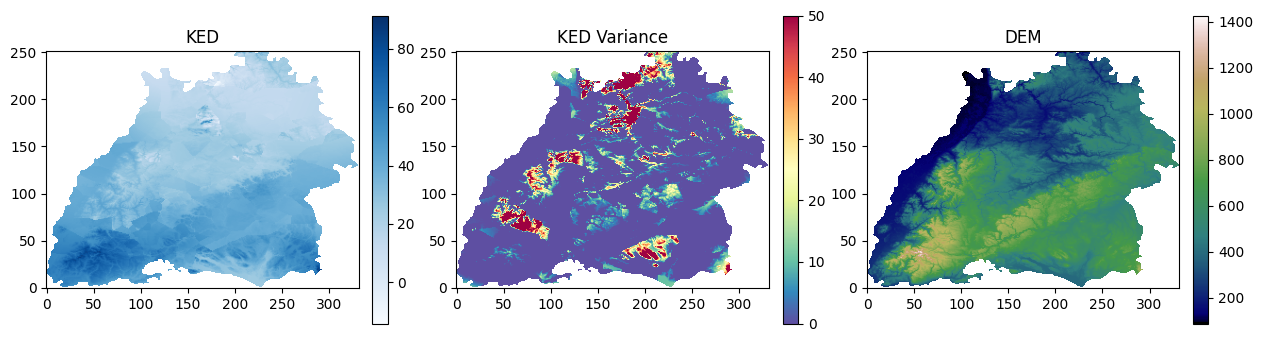

In [ ]:
fig, _a = plt.subplots(1, 3, figsize=(15, 4))
axes = _a.flatten()

m = axes[0].imshow(np.flipud(pred.reshape((332, 252)).T), cmap='Blues', origin='lower')
plt.colorbar(m, ax=axes[0], fraction=0.046, pad=0.04)
axes[0].set_title('KED')

m = axes[1].imshow(np.flipud(var.reshape((332, 252)).T), cmap='Spectral_r', origin='lower',vmin=0, vmax=50)
plt.colorbar(m, ax=axes[1], fraction=0.046, pad=0.04)
axes[1].set_title('KED Variance')

m = axes[2].imshow(np.flipud(dem_vals.reshape((332, 252)).T), cmap='gist_earth', origin='lower')
plt.colorbar(m, ax=axes[2], fraction=0.046, pad=0.04)
axes[2].set_title('DEM')
